# EfficientNetB3 Model Training Process
### Training an EfficientNetB3 model to classify between Real and AI generated images.
### Model Developer: Tesneem Essa  ||  Assisted by: Keira James, Georgios Ioannou
### Dataset Created and Cleaned by: Farhikhta Farzan


# Loading Libraries 
### We begin by first loading in the necessary libraries. The training will be done using the TensorFlow Keras Application.

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, models, optimizers
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

E0000 00:00:1732402042.329575      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1123 22:47:22.337726001      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1123 22:47:22.337739399      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1123 22:47:22.337742644      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1123 22:47:22.337744892      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1123 22:47:22.337747462      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

# TPU Strategy
### Next, we check for the TPU and create a TPU strategy on which our model will be compiled, trained, and tested. If TPU is not found, we make sure to default to a a CPU/GPU strategy.

In [ ]:
# Check for TPU
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default to CPU/GPU strategy if TPU is not found

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1732402053.776734      13 service.cc:145] XLA service 0x56101aff8aa0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732402053.776794      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1732402053.776799      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1732402053.776802      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1732402053.776807      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1732402053.776809      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1732402053.776812      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1732402053.776815      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1732402053.776817      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

# Loading Train and Val Data
### We define a function to augment images by applying random flips and brightness adjustments. This augmentation introduces variability, helping the model generalize better and reducing the risk of overfitting. Next, we load in the train dataset using Keras ImageDataGen and split it so that 20% of the train data is used for validation testing. We also load in our images with the size (300,300) as this is the target size for the EfficientNetB3 model.

In [ ]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Randomly flip images
    image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness
    return image, label
train_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/ai-vs-real-dataset/_DATASET/dataset/train',
    image_size=(300, 300),
    batch_size=128,
    shuffle=True,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=123 #must be the same as for val_data
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/ai-vs-real-dataset/_DATASET/dataset/train',
    image_size=(300, 300),
    batch_size=128,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123
)
train_data = train_data.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
# Prefetch to improve performance
train_data = train_data.prefetch(tf.data.AUTOTUNE)

Found 87408 files belonging to 2 classes.
Using 69927 files for training.
Found 87408 files belonging to 2 classes.
Using 17481 files for validation.


# Load and Compile Model
### Next, we load in the EfficientNetB3 model as our base model and exclude the top layer. Again the input shape is (300,300) and we make sure to make this base model untrainable for fine tuning. Then we add in our custom layers using the functional API:
#### GlobalAveragePooling2D layer computes the average value of each feature map across spatial dimensions, overall reducing the spatial dimensions of the model’s output and bridging the feature extraction layers to the dense layers. 
#### Dense layer 128 units and ReLU activation adds a fully connected layer on top of the pooled features, allowing for more complex learning for the specific task of binary classification that our project is trying to accomplish. 
#### Dropout layer to further prevent overfitting by randomly deactivating neurons, thereby enhancing generalization.
#### A final Dense layer with sigmoid activation is then added to compound the output between 0 and 1 for classification. 
#### Finally, I compiled with ‘Adam’ optimizer, which combines adaptive learning rates with momentum, and is often used by CNN’s.
#### The second parameter for compiling is the binary cross-entropy loss, which is suitable for binary classification, as it evaluates the difference between predicted probabilities and actual labels.
#### And the last parmeter is the metric for evaluating model performance, which I chose to be ‘accuracy’.


In [ ]:
# Load the EfficientNet base model
with strategy.scope():
  
    base_model = tf.keras.applications.EfficientNetB3(
        weights="/kaggle/input/efficientnetb3-notoph5/efficientnetb3_notop.h5",  # Use pre-trained weights
        include_top=False,   # Exclude the classifier head
        input_shape=(300, 300, 3)  # Adjust to EfficientNetB3's input size
    )

# Freeze the base model layers during the first training phase
    base_model.trainable = False
# Build the custom model
    inputs = tf.keras.Input(shape=(300, 300, 3))
    x = base_model(inputs, training=False)  # Keep base model frozen
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)  # Regularization
    outputs = layers.Dense(1, activation="sigmoid")(x)  # Binary classification

    model = models.Model(inputs, outputs)

# Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    model.summary()

I0000 00:00:1732402226.414719      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,980,400 (41.89 MB)

 Trainable params: 196,865 (769.00 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

# Model Fit
### Now we can start training our model. We use the history=model.fit() so that we can later plot our train and validation accuracy and loss. We set the starting epochs for 15 and add EarlyStopping and ReduceLROnPlateau callbacks to ensure our model is improving in it's training. These callbacks are set to monitor validation loss as this is a good inidicator of a model's performance in terms of generalization and overfititng.

In [ ]:
with strategy.scope():
    history = model.fit(
        train_data,  
        validation_data=val_data,
        epochs=15,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
        ]
    )

Epoch 1/15


2024-11-23 22:51:10.572501: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1732402273.495714     813 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(92d1db5660fc6155:0:0), session_name()
I0000 00:00:1732402318.316498     813 tpu_compile_op_common.cc:245] Compilation of 92d1db5660fc6155:0:0 with session name  took 44.820701323s and succeeded
I0000 00:00:1732402318.428517     813 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(92d1db5660fc6155:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1568928126473911795", property.function_library_fingerprint = 354415044868241532, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 

546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8210 - loss: 0.3884

I0000 00:00:1732402381.400134     773 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(4de9de6d28ec10ca:0:0), session_name()
I0000 00:00:1732402422.941184     773 tpu_compile_op_common.cc:245] Compilation of 4de9de6d28ec10ca:0:0 with session name  took 41.541003613s and succeeded
I0000 00:00:1732402423.079522     773 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(4de9de6d28ec10ca:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1568928126473911795", property.function_library_fingerprint = 354415044868241532, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "5,300,300,3,;5,;", property.guaranteed_constants_size = 0, embeddin

547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8211 - loss: 0.3882

2024-11-23 22:53:48.731305: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1732402429.736116     809 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(67ba0b4ab4b6345c:0:0), session_name()
I0000 00:00:1732402438.199222     809 tpu_compile_op_common.cc:245] Compilation of 67ba0b4ab4b6345c:0:0 with session name  took 8.463048252s and succeeded
I0000 00:00:1732402438.217827     809 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(67ba0b4ab4b6345c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_3654818894138208684", property.function_library_fingerprint = 17184398301921755350, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, t


Epoch 1: val_loss improved from inf to 0.22920, saving model to /kaggle/working/efficientnetb3_binary_classifier_pre_8.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 208s 277ms/step - accuracy: 0.8212 - loss: 0.3881 - val_accuracy: 0.9076 - val_loss: 0.2292 - learning_rate: 0.0010
Epoch 2/15
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8910 - loss: 0.2596
Epoch 2: val_loss improved from 0.22920 to 0.20956, saving model to /kaggle/working/efficientnetb3_binary_classifier_pre_8.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 87s 157ms/step - accuracy: 0.8910 - loss: 0.2595 - val_accuracy: 0.9149 - val_loss: 0.2096 - learning_rate: 0.0010
Epoch 3/15
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9074 - loss: 0.2279
Epoch 3: val_loss improved from 0.20956 to 0.19180, saving model to /kaggle/working/efficientnetb3_binary_classifier_pre_8.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 86s 154ms/step - accuracy: 0.9074 - loss: 0.2279 - val_accuracy: 0.9181 - val_loss: 0.1918 - learning_rate: 0.0010
Epoch 4

# Model Accuracy and Loss
### After this we plot our Model Accuracy and Model Loss Charts. The model seems to be underfitting a bit as validation accuracy is higher than that of the training, but this is most likely due to data augmentation and the dropout layer that is applied to the training data. The plot also shows convergance at the 15th epochs, which is a good sign of a well balanced model.

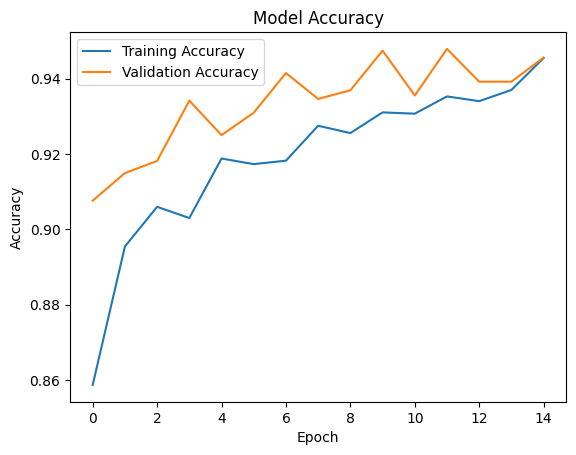

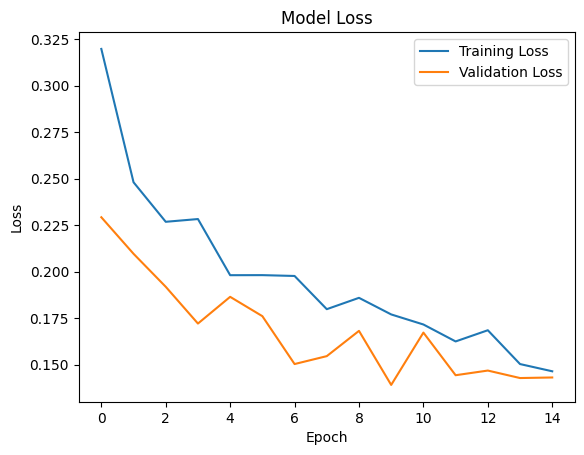

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Test Model
### Next, we load in our test data, with a smaller batch size, and create a confusion matrix based on the model's predictions. This is to compare the model's behavior pre and post fine tuning.

Found 21852 files belonging to 2 classes.


2024-11-23 23:20:53.232303: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1732404053.931871     773 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(a15815e668274a0c:0:0), session_name()


  1/342 ━━━━━━━━━━━━━━━━━━━━ 1:01:49 11s/step

I0000 00:00:1732404060.323367     773 tpu_compile_op_common.cc:245] Compilation of a15815e668274a0c:0:0 with session name  took 6.391447695s and succeeded
I0000 00:00:1732404060.343658     773 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a15815e668274a0c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_10507187721626393510", property.function_library_fingerprint = 4606300528783900204, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732404060.343704     773 tpu_compilation_cache_interface.cc:541] After adding entry for key a15815e6682

341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step

2024-11-23 23:21:54.823541: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1732404115.687114     746 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(92049cb173dec1f8:0:0), session_name()


342/342 ━━━━━━━━━━━━━━━━━━━━ 73s 181ms/step


I0000 00:00:1732404122.187016     746 tpu_compile_op_common.cc:245] Compilation of 92049cb173dec1f8:0:0 with session name  took 6.499840095s and succeeded
I0000 00:00:1732404122.201494     746 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(92049cb173dec1f8:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11703093510848980231", property.function_library_fingerprint = 13525693609192228421, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,300,300,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732404122.201529     746 tpu_compilation_cache_interface.cc:541] After adding entry fo

Confusion Matrix:
[[10185   741]
 [  546 10380]]
Classification Report:
              precision    recall  f1-score   support

        FAKE       0.95      0.93      0.94     10926
        REAL       0.93      0.95      0.94     10926

    accuracy                           0.94     21852
   macro avg       0.94      0.94      0.94     21852
weighted avg       0.94      0.94      0.94     21852

Accuracy: 0.9411037891268533
Precision: 0.9333693013218236
Recall: 0.9500274574409665
F1 Score: 0.941624710845013


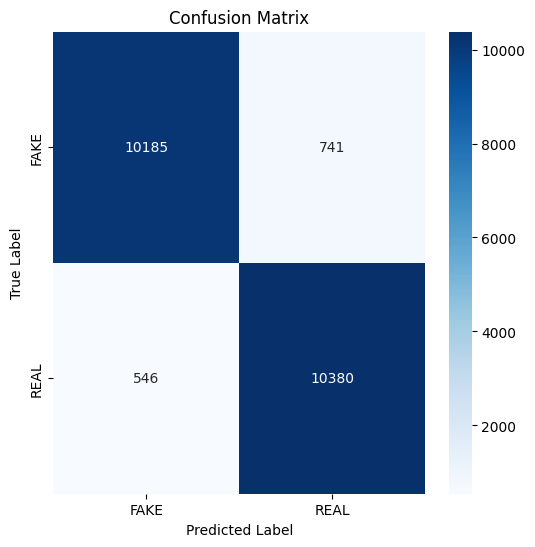

In [ ]:
#Load test dataset
test_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/ai-vs-real-dataset/_DATASET/dataset/test',  
    image_size=(300, 300),
    batch_size=64,
    shuffle=False  # Important to keep the order for predictions
)

# Extract true labels from the dataset
y_true = np.concatenate([y.numpy() for x, y in test_data], axis=0)
class_names = ['FAKE', 'REAL']

# Make predictions
with strategy.scope():
    predictions = model.predict(test_data)

# Convert predictions to binary labels
y_pred = (predictions > 0.5).astype("int32").flatten()  # Flatten to match shape of y_true

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot confusion matrix for better visualization
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Fine Tune Model
### Now, we can start fine tuning. We start by unfreezing all the layers in the model, and then freezing some of the layers, specifically the first 100. We then compile the model again with a lower learning rate to help with convergance. We train our model the same as before and make sure to save the final model.

In [ ]:
with strategy.scope():
# Unfreeze the base model
    base_model.trainable = True 
    fine_tune_at = 100 
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
# Use a lower learning rate for fine-tuning
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

# Fine-tune the entire model
    fine_tune_history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,  #Adjusted the epochs based on performance
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
        ]
    )
    model.save("/kaggle/working/efficientnetb3_binary_classifier_8.h5")

Epoch 1/20


I0000 00:00:1732404167.245335     752 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(bc115f4e52397cb0:0:0), session_name()
I0000 00:00:1732404236.323862     752 tpu_compile_op_common.cc:245] Compilation of bc115f4e52397cb0:0:0 with session name  took 1m9.078477701s and succeeded
I0000 00:00:1732404236.559815     752 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(bc115f4e52397cb0:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13399412060353645539", property.function_library_fingerprint = 2420744844956129240, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16,300,300,3,;16,;", property.guaranteed_constants_size = 0, emb

546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7482 - loss: 0.9922

I0000 00:00:1732404335.403815     830 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f49ba6ae1c71a4fd:0:0), session_name()
I0000 00:00:1732404398.318845     830 tpu_compile_op_common.cc:245] Compilation of f49ba6ae1c71a4fd:0:0 with session name  took 1m2.914960705s and succeeded
I0000 00:00:1732404398.559428     830 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f49ba6ae1c71a4fd:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13399412060353645539", property.function_library_fingerprint = 2420744844956129240, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "5,300,300,3,;5,;", property.guaranteed_constants_size = 0, embed

547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.7483 - loss: 0.9916

2024-11-23 23:26:45.295912: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1732404406.424326     790 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(988d22802105bd95:0:0), session_name()
I0000 00:00:1732404415.024966     790 tpu_compile_op_common.cc:245] Compilation of 988d22802105bd95:0:0 with session name  took 8.600589964s and succeeded
I0000 00:00:1732404415.042508     790 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(988d22802105bd95:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_11296259099955844135", property.function_library_fingerprint = 17299378159147668744, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, 

547/547 ━━━━━━━━━━━━━━━━━━━━ 294s 367ms/step - accuracy: 0.7484 - loss: 0.9911 - val_accuracy: 0.9012 - val_loss: 0.2502 - learning_rate: 1.0000e-05
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 122s 220ms/step - accuracy: 0.8649 - loss: 0.3438 - val_accuracy: 0.9222 - val_loss: 0.1909 - learning_rate: 1.0000e-05
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 118s 213ms/step - accuracy: 0.8940 - loss: 0.2656 - val_accuracy: 0.9350 - val_loss: 0.1614 - learning_rate: 1.0000e-05
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 121s 218ms/step - accuracy: 0.9095 - loss: 0.2228 - val_accuracy: 0.9552 - val_loss: 0.1337 - learning_rate: 1.0000e-05
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 119s 215ms/step - accuracy: 0.9260 - loss: 0.1868 - val_accuracy: 0.9533 - val_loss: 0.1212 - learning_rate: 1.0000e-05
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 122s 221ms/step - accuracy: 0.9347 - loss: 0.1748 - val_accuracy: 0.9611 - val_loss: 0.1049 - learning_rate: 1.0000e-05
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 120s 217ms/

# Fine Tuned Model Accuracy and Loss
### Now we have our final Model Accuracy and Loss plots. The model shows significant improvement as the accuracy and training lines converge and the loss graph has a smoother descent.

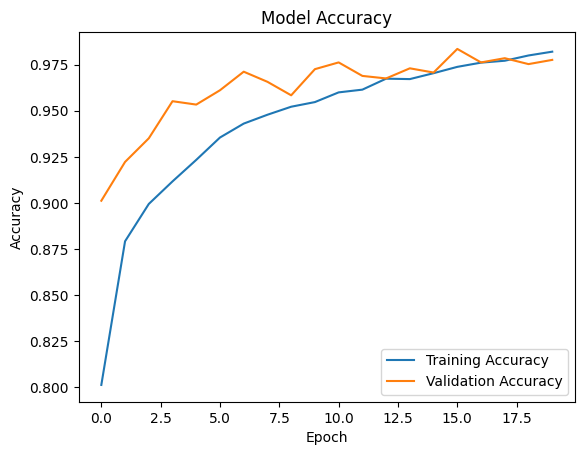

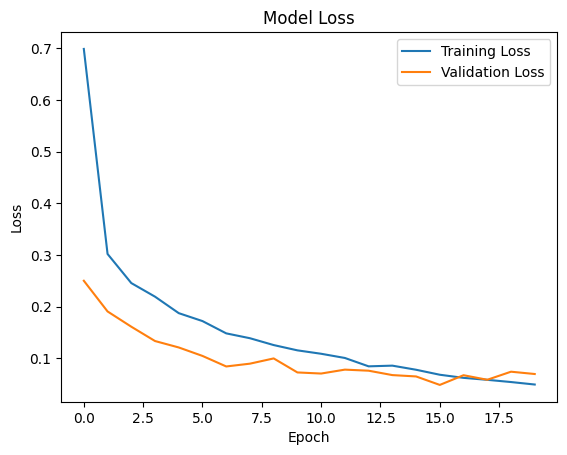

In [ ]:
# Plot training & validation accuracy values
plt.plot(fine_tune_history.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Plot training & validation loss values
plt.plot(fine_tune_history.history['loss'], label='Training Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Test Fine Tuned Model
### Again we test our model using the test data and see a huge improvement from the pre fine tuned model. 

Found 21852 files belonging to 2 classes.


2024-11-24 00:05:41.336297: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1732406742.078734     788 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ace9dfe4be9d5021:0:0), session_name()


  1/342 ━━━━━━━━━━━━━━━━━━━━ 1:03:01 11s/step

I0000 00:00:1732406748.441015     788 tpu_compile_op_common.cc:245] Compilation of ace9dfe4be9d5021:0:0 with session name  took 6.36221514s and succeeded
I0000 00:00:1732406748.460891     788 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ace9dfe4be9d5021:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14653908531256888841", property.function_library_fingerprint = 14183112832342250709, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732406748.460932     788 tpu_compilation_cache_interface.cc:541] After adding entry for key ace9dfe4be9

341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step

2024-11-24 00:06:41.936529: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1732406802.801393     802 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(861f5708489a8a32:0:0), session_name()


342/342 ━━━━━━━━━━━━━━━━━━━━ 72s 178ms/step


I0000 00:00:1732406809.266423     802 tpu_compile_op_common.cc:245] Compilation of 861f5708489a8a32:0:0 with session name  took 6.464984s and succeeded
I0000 00:00:1732406809.286035     802 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(861f5708489a8a32:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14863858362985618665", property.function_library_fingerprint = 3373325191560155656, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,300,300,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732406809.286087     802 tpu_compilation_cache_interface.cc:541] After adding entry for ke

Confusion Matrix:
[[10640   286]
 [  212 10714]]
Classification Report:
              precision    recall  f1-score   support

        FAKE       0.98      0.97      0.98     10926
        REAL       0.97      0.98      0.98     10926

    accuracy                           0.98     21852
   macro avg       0.98      0.98      0.98     21852
weighted avg       0.98      0.98      0.98     21852

Accuracy: 0.9772103239978034
Precision: 0.974
Recall: 0.9805967417170053
F1 Score: 0.9772872388944632


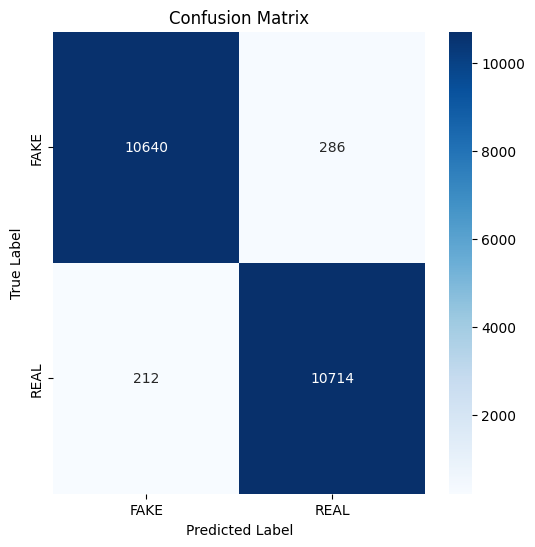

In [ ]:
# Load the test dataset
test_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/ai-vs-real-dataset/_DATASET/dataset/test',  
    image_size=(300, 300),
    batch_size=64,
    shuffle=False  
)


# Extract true labels from the dataset
y_true = np.concatenate([y.numpy() for x, y in test_data], axis=0)
class_names = ['FAKE', 'REAL']

# Make predictions
with strategy.scope():
    predictions = model.predict(test_data)

# Convert predictions to binary labels
y_pred = (predictions > 0.5).astype("int32").flatten()  # Flatten to match shape of y_true

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot confusion matrix for better visualization
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Model Evaluation
### Evaluating our model we find that it's accuracy is 98.1%

In [ ]:
with strategy.scope():
    test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")


I0000 00:00:1732406811.001915     740 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(2ee2407f636f7220:0:0), session_name()


  3/342 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 1.0000 - loss: 2.3669e-05

I0000 00:00:1732406817.629962     740 tpu_compile_op_common.cc:245] Compilation of 2ee2407f636f7220:0:0 with session name  took 6.627988541s and succeeded
I0000 00:00:1732406817.646537     740 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(2ee2407f636f7220:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_11296259099955844135", property.function_library_fingerprint = 17299378159147668744, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "8,300,300,3,;8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732406817.646568     740 tpu_compilation_cache_interface.cc:541] After adding entry for key 2e

340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9835 - loss: 0.0471

I0000 00:00:1732406834.289489     746 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f2b8040823c11e1:0:0), session_name()


342/342 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.9835 - loss: 0.0472
Test Accuracy: 0.9810


I0000 00:00:1732406840.798107     746 tpu_compile_op_common.cc:245] Compilation of f2b8040823c11e1:0:0 with session name  took 6.50857894s and succeeded
I0000 00:00:1732406840.814934     746 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f2b8040823c11e1:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_11296259099955844135", property.function_library_fingerprint = 17299378159147668744, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,300,300,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732406840.814972     746 tpu_compilation_cache_interface.cc:541] After adding entry for key f2b80

# Check saved model
### Evaluating again after loading the saved model to ensure it was saved properly. 

In [ ]:
with strategy.scope():
    model = tf.keras.models.load_model('/kaggle/working/efficientnetb3_binary_classifier_8.h5')
    test_loss, test_accuracy = model.evaluate(test_data)
    print(f"Test Accuracy: {test_accuracy:.4f}")



I0000 00:00:1732406856.744429     777 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(a36d39b6ed184f:0:0), session_name()


  3/342 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 1.0000 - loss: 2.3669e-05 

I0000 00:00:1732406863.273446     777 tpu_compile_op_common.cc:245] Compilation of a36d39b6ed184f:0:0 with session name  took 6.528971173s and succeeded
I0000 00:00:1732406863.290534     777 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a36d39b6ed184f:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_3059974571539174876", property.function_library_fingerprint = 11353381672325322100, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "8,300,300,3,;8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732406863.290571     777 tpu_compilation_cache_interface.cc:541] After adding entry for key a36d39b

341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9835 - loss: 0.0472

I0000 00:00:1732406880.229569     806 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(efd304d606af96df:0:0), session_name()


342/342 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - accuracy: 0.9835 - loss: 0.0472
Test Accuracy: 0.9810


I0000 00:00:1732406886.883093     806 tpu_compile_op_common.cc:245] Compilation of efd304d606af96df:0:0 with session name  took 6.653482425s and succeeded
I0000 00:00:1732406886.904296     806 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(efd304d606af96df:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_3059974571539174876", property.function_library_fingerprint = 11353381672325322100, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,300,300,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732406886.904350     806 tpu_compilation_cache_interface.cc:541] After adding entry for key efd

# Test on Unseen Data
### Finally, we use a small set of unseen data outside of our training and test data to evaluate our model. As you can see, the model isn't 100% accurate, but it does a adequate job at classifying for unseen data. 

2024-11-24 00:08:11.630178: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1732406892.348831     751 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(a43169843ffed322:0:0), session_name()


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


I0000 00:00:1732406898.431478     751 tpu_compile_op_common.cc:245] Compilation of a43169843ffed322:0:0 with session name  took 6.082597987s and succeeded
I0000 00:00:1732406898.451343     751 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a43169843ffed322:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_16145606416339916768", property.function_library_fingerprint = 16158277672820171060, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,300,300,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732406898.451386     751 tpu_compilation_cache_interface.cc:541] After adding entry for k

Prediction: Real


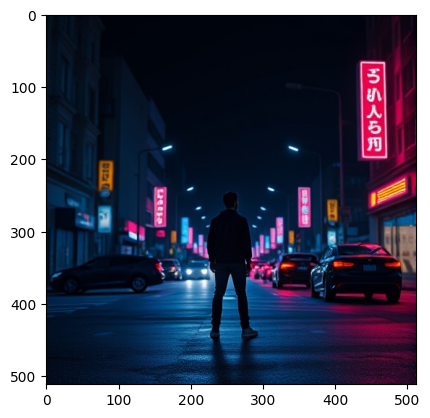

Prediction for fake(2).jpeg in FAKE: [0.99999934]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
Prediction: Real


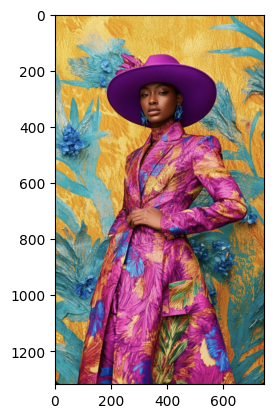

Prediction for fake.png in FAKE: [0.9999083]
FAKE
REAL:  2
FAKE:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
Prediction: Real
Prediction for real.png in REAL: [0.99999726]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
Prediction: Real
Prediction for real(3).jpg in REAL: [0.8098874]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
Prediction: Fake


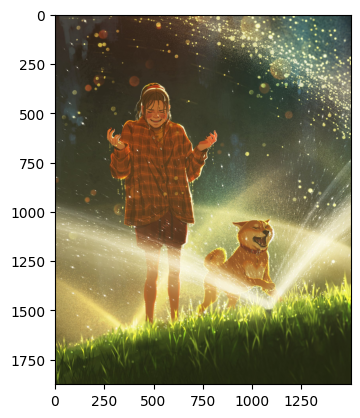

Prediction for real(4).jpg in REAL: [3.1888485e-06]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
Prediction: Real
Prediction for real(2).jpeg in REAL: [0.9876019]
REAL
REAL:  3
FAKE:  1


In [ ]:

#Image testing on unseen data

# test_directory = '/kaggle/input/ai-vs-real-dataset/_DATASET/dataset/test'
test_directory="/kaggle/input/test-set/test"
image_size = (300, 300)
# Function to load and preprocess a single image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=image_size)  # Load the image
    img_array = image.img_to_array(img)                      # Convert to array
    img_array = np.expand_dims(img_array, axis=0)            # Add batch dimension
    return img_array
#testing directory_size/i images in a directory
for label in ["FAKE", "REAL"]:
    fake_count=0
    real_count=0
    i=0
    label_dir = f"{test_directory}/{label}"
    for img_name in os.listdir(label_dir):
        if i%1==0:
            img_path = f"{label_dir}/{img_name}"
            img_array = load_and_preprocess_image(img_path)
        
        # Make a prediction using the model
            prediction = model.predict(img_array)
    
        # Process the prediction as needed
             # Output the label based on probability
            if prediction[0] > 0.5:
                print("Prediction: Real")
                real_count+=1
                if label=="FAKE":
                    img = mpimg.imread(img_path)
                    plt.imshow(img)
                    plt.show()
            else:
                print("Prediction: Fake")
                fake_count+=1
                if label=="REAL":
                    img = mpimg.imread(img_path)
                    plt.imshow(img)
                    plt.show()
            print(f"Prediction for {img_name} in {label}: {prediction[0]}")
        i+=1
    print(label)
    print("REAL: ",real_count)  
    print("FAKE: ",fake_count)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
Prediction: Fake
Prediction for test_image_2.jpg in FAKE: [0.00106499]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
Prediction: Real


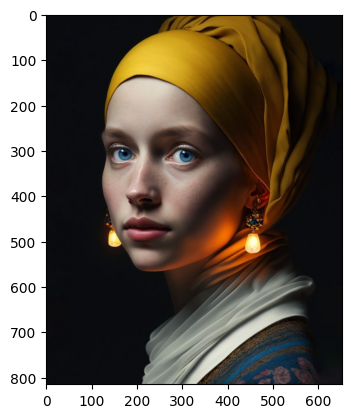

Prediction for Julian-van-Dieken_A-Girl-With-Glowing-Earrings-.jpg in FAKE: [0.9994676]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
Prediction: Fake
Prediction for natural.jpg in FAKE: [0.12294126]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
Prediction: Fake
Prediction for test_normal.jpeg in FAKE: [0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
Prediction: Real


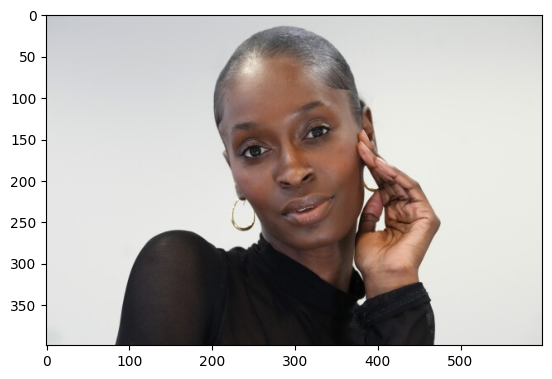

Prediction for download.jpg in FAKE: [1.]
FAKE
REAL:  2
FAKE:  3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
Prediction: Fake


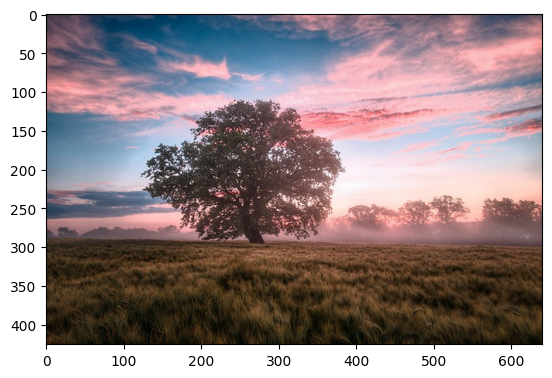

Prediction for test_image.jpg in REAL: [0.01483849]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
Prediction: Real
Prediction for istockphoto-1364387823-612x612.jpg in REAL: [0.99389404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
Prediction: Real
Prediction for flowers.jpg in REAL: [0.99986154]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
Prediction: Real
Prediction for sad_person.jpg in REAL: [0.99969155]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
Prediction: Real
Prediction for rainbow.jpg in REAL: [0.89597404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
Prediction: Real
Prediction for happy.jpg in REAL: [0.99994105]
REAL
REAL:  5
FAKE:  1


In [ ]:

# test_directory = '/kaggle/input/ai-vs-real-dataset/_DATASET/dataset/test'
test_directory="/kaggle/input/image-testing/Images_Testing"
image_size = (300, 300)
# Function to load and preprocess a single image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=image_size)  # Load the image
    img_array = image.img_to_array(img)                      # Convert to array
    img_array = np.expand_dims(img_array, axis=0)            # Add batch dimension
    return img_array
#testing directory_size/i images in a directory
for label in ["FAKE", "REAL"]:
    fake_count=0
    real_count=0
    i=0
    label_dir = f"{test_directory}/{label}"
    for img_name in os.listdir(label_dir):
        if i%1==0:
            img_path = f"{label_dir}/{img_name}"
            img_array = load_and_preprocess_image(img_path)
        
        # Make a prediction using the model
            prediction = model.predict(img_array)
    
        # Process the prediction as needed
             # Output the label based on probability
            if prediction[0] > 0.5:
                print("Prediction: Real")
                real_count+=1
                if label=="FAKE":
                    img = mpimg.imread(img_path)
                    plt.imshow(img)
                    plt.show()
            else:
                print("Prediction: Fake")
                fake_count+=1
                if label=="REAL":
                    img = mpimg.imread(img_path)
                    plt.imshow(img)
                    plt.show()
            print(f"Prediction for {img_name} in {label}: {prediction[0]}")
        i+=1
    print(label)
    print("REAL: ",real_count)  
    print("FAKE: ",fake_count)